In [23]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import zipfile
from io import BytesIO

import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests

from PIL import Image
from sklearn.preprocessing import MinMaxScaler
import keras
from keras import ops


In [9]:
RESOLUTION = 224
PATCH_SIZE = 15
GITHUB_RELEASE = "https://github.com/sayakpaul/probing-vits/releases/download/v1.0.0/probing_vits.zip"
FNAME = "probing_vits.zip"
MODELS_ZIP = {
    "vit_dino_base16": "Probing_ViTs/vit_dino_base16.zip",
    "vit_b16_patch16_224": "Probing_ViTs/vit_b16_patch16_224.zip",
    "vit_b16_patch16_224-i1k_pretrained": "Probing_ViTs/vit_b16_patch16_224-i1k_pretrained.zip",
}

In [20]:
crop_layer = keras.layers.CenterCrop(RESOLUTION, RESOLUTION)
norm_layer = keras.layers.Normalization(
    mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
    variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],
)
rescale_layer = keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1)


def preprocess_image(image, model_type, size=RESOLUTION):
    # Turn the image into a numpy array and add batch dim.
    image = np.array(image)
    image = ops.expand_dims(image, 0)

    # If model type is vit rescale the image to [-1, 1].
    if model_type == "original_vit":
        image = rescale_layer(image)

    # Resize the image using bicubic interpolation.
    resize_size = int((256 / 224) * size)
    image = ops.image.resize(image, (resize_size, resize_size), interpolation="bicubic")

    # Crop the image.
    image = crop_layer(image)

    # If model type is DeiT or DINO normalize the image.
    if model_type != "original_vit":
        image = norm_layer(image)

    return ops.convert_to_numpy(image)


def load_image_from_url(url, model_type):
    # Credit: Willi Gierke
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    preprocessed_image = preprocess_image(image, model_type)
    return image, preprocessed_image


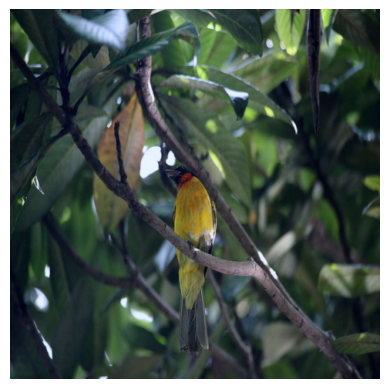

In [21]:
# ImageNet-1k label mapping file and load it.

mapping_file = keras.utils.get_file(
    origin="https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt"
)

with open(mapping_file, "r") as f:
    lines = f.readlines()
imagenet_int_to_str = [line.rstrip() for line in lines]

img_url = "https://dl.fbaipublicfiles.com/dino/img.png"
image, preprocessed_image = load_image_from_url(img_url, model_type="original_vit")

plt.imshow(image)
plt.axis("off")
plt.show()


In [24]:
zip_path = keras.utils.get_file(
    fname=FNAME,
    origin=GITHUB_RELEASE,
)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("./")

os.rename("Probing ViTs", "Probing_ViTs")


def load_model(model_path: str) -> keras.Model:
    with zipfile.ZipFile(model_path, "r") as zip_ref:
        zip_ref.extractall("Probing_ViTs/")
    model_name = model_path.split(".")[0]

    inputs = keras.Input((RESOLUTION, RESOLUTION, 3))
    model = keras.layers.TFSMLayer(model_name, call_endpoint="serving_default")
    outputs = model(inputs, training=False)

    return keras.Model(inputs, outputs=outputs)


vit_base_i21k_patch16_224 = load_model(MODELS_ZIP["vit_b16_patch16_224-i1k_pretrained"])
print("Model loaded.")


BadZipFile: File is not a zip file